In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()

train_norm = (train - mean)/std
test_norm = (test - mean)/std

In [7]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [8]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [6]:
CalcRMSE(test, np.array([mean]*500000))

0.6833819356109927

In [9]:
lstm_bin_predicts = np.load("lstm_predicts_as_bin.npy")

In [10]:
test_right_part = (len(test)- 20)%64
lstm_bin_rmses = []
lstm_bin_rmses.append(CalcRMSE(int_to_amp(lstm_bin_predicts[0][1:], data), test[20:-test_right_part]))
for i in range(1, 19):
    lstm_bin_rmses.append(CalcRMSE(int_to_amp(lstm_bin_predicts[i][1:], data, n=256)[:-i], test[20+i: -test_right_part]))

In [11]:
lstm_rmse_cont = np.load("predicts/lstm_rmse.npy")
wave_net_predicts_bin = np.load("predicts/wavenet_predict_all_steps.npy")
wavenet_rmses_bin = []
for i in range(19):
    wavenet_rmses_bin.append(CalcRMSE(int_to_amp(wave_net_predicts_bin[:, 1:][i], data, n=256)[:-1-i], data[-499999 + i:]))

In [12]:
wave_net_predicts_cont = np.load("wavenet_predict_all_steps_cont.npy")
wavenet_rmses_cont = []
for i in range(19):
    wavenet_rmses_cont.append(CalcRMSE(wave_net_predicts_cont[:, 1:][i][:-1-i], data[-499999 + i:]))

In [13]:
transformer_rmse_cont = np.load("predicts/transformer_rmse.npy")
transformer_rmse_bin = np.load('predicts/trans_rmses_bin.npy')

In [14]:
trainLen = 1250000
testLen = 249999

rc_data = data[1000:]

rc_all_predicts_cont = np.load('predicts/rc_all_predicts_res_best_params.npy')
rc_rmses_cont = []
rc_rmses_cont.append(CalcRMSE(rc_all_predicts_cont[0][1:], rc_data[trainLen+1:trainLen + testLen+1]))
for i in range(1, 19):
    rc_rmses_cont.append(CalcRMSE(np.clip(rc_all_predicts_cont[i][1:-i], rc_data.min(), rc_data.max()), 
                                  rc_data[trainLen+1+i:trainLen + testLen+1]))
    
rc_predicts_bin = np.load('predicts/rc_all_predicts_bin_res_best_params.npy')
rc_bin_rmses = []
rc_bin_rmses.append(CalcRMSE(int_to_amp(rc_predicts_bin[0][1:], data), data[trainLen+1:trainLen + testLen+1]))
for i in range(1, 19):
    rc_bin_rmses.append(CalcRMSE(int_to_amp(rc_predicts_bin[i][1:], data, n=256)[:-i], data[trainLen+1+i:trainLen + testLen+1]))

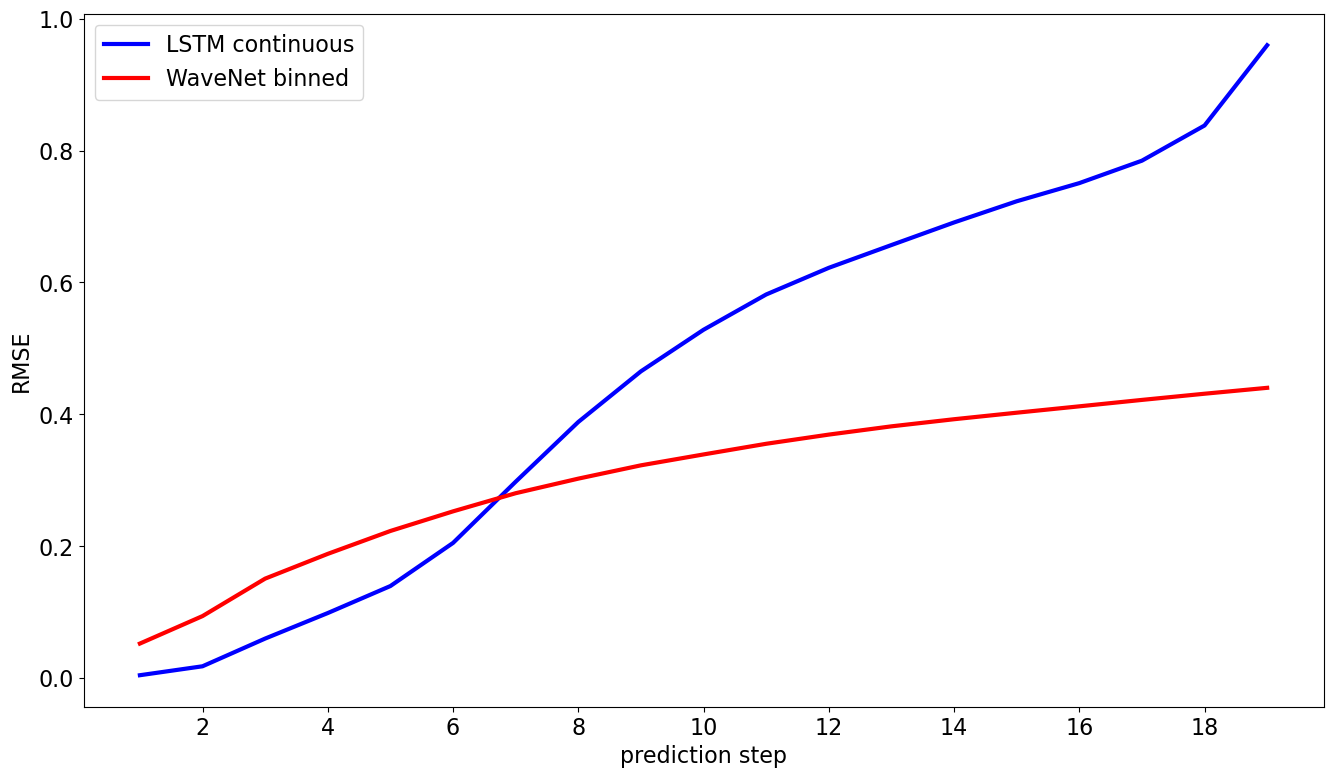

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(list(range(1, 20)), lstm_rmse_cont, label="LSTM continuous", color="b", linewidth = 3)


ax.plot(list(range(1, 20)), wavenet_rmses_bin, label="WaveNet binned", color="r", linewidth = 3)


ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

ax.legend(fontsize = 16)

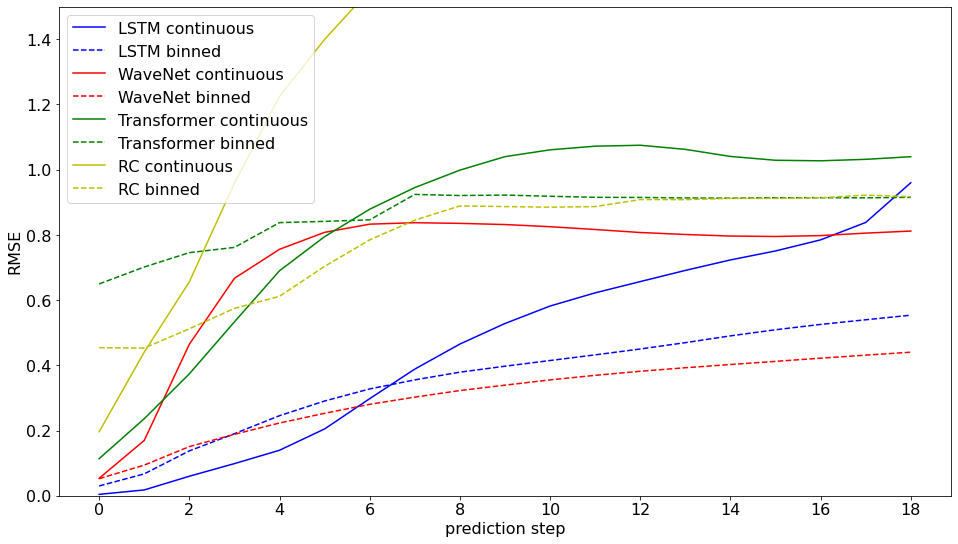

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(lstm_rmse_cont, label="LSTM continuous", color="b")
ax.plot(lstm_bin_rmses, label="LSTM binned", color="b", linestyle='dashed')

ax.plot(wavenet_rmses_cont, label="WaveNet continuous", color="r")
ax.plot(wavenet_rmses_bin, label="WaveNet binned", color="r", linestyle='dashed')

ax.plot(transformer_rmse_cont, label="Transformer continuous", color="g")
ax.plot(transformer_rmse_bin, label="Transformer binned", color="g", linestyle='dashed')

ax.plot(rc_rmses_cont, label="RC continuous", color="y")
ax.plot(rc_bin_rmses, label="RC binned", color="y", linestyle='dashed')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)
ax.set_ylim(0, 1.5)
ax.legend(fontsize = 16)